<h1> [Sleep-2-Learn] Part II - Learning </h1>

# Sleep-2-Learn: Learning Sleep

In [1]:
## Check envirionment

try:
    from google.colab import drive
    
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Runtime has {:.1f} GB of available RAM\n'.format(ram_gb))

    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    LAB_PATH = '/content/drive/MyDrive/+Research/__SLEEP__Workspace/[Sleep-2-Learn]_dev/'
    print("NOTE: Running on Google CoLab")
except:
    print("NOTE: Not using Google CoLab")
    COLAB = False
    LAB_PATH = ''


NOTE: Not using Google CoLab


## Import Libraries

In [2]:
import os

import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
from matplotlib import dates as plotdates

from enum import Enum
#from tqdm.auto import tqdm
import itertools

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier, OutputCodeClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score, matthews_corrcoef

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import pickle

import warnings


In [3]:
#import sklearn
#print(sklearn.__version__)

# *** sklearn version >= 0.22 or higher can calculate multiclass AUC
# current version = 0.24.2

In [4]:
# Get rid of warnings
warnings.simplefilter("ignore")


## Set Up

In [5]:
class ClfAlgorithm(Enum):
  
    # Setup based classifiers for tuning (same as Walch's)
    LR = LogisticRegression(penalty='l1',
                            solver='liblinear',
                            verbose=0,
                            multi_class='ovr')
    
    KN = KNeighborsClassifier(weights='distance')
    
    RF = RandomForestClassifier(n_estimators=100,
                                max_features=1.0,
                                max_depth=10,
                                min_samples_split=10,
                                min_samples_leaf=32,
                                bootstrap=True)
    
    NN = MLPClassifier(activation='relu',
                       hidden_layer_sizes=(15, 15, 15),
                       max_iter=1000,
                       alpha=0.01,
                       solver='lbfgs',
                       verbose=False,
                       n_iter_no_change=20)
    
    XGB = XGBClassifier(verbosity=0)


In [6]:
class BestClf(Enum):
        # Setup best classifiers (that has been tuned hyperparameters)
    LR = LogisticRegression(penalty='l1',
                            solver='liblinear',
                            verbose=0,
                            multi_class='ovr')
    
    KN = KNeighborsClassifier(weights='distance')
    
    RF = RandomForestClassifier(bootstrap=True,
                                criterion='gini', 
                                max_depth=80, 
                                max_features=1.0,
                                min_samples_leaf=10, 
                                min_samples_split=10,
                                n_estimators=300)
    
    NN = MLPClassifier(activation='relu',
                       hidden_layer_sizes=(30, 30, 30),
                       max_iter=2000,
                       alpha=0.01,
                       solver='lbfgs',
                       verbose=False,
                       n_iter_no_change=20)
    
    XGB = XGBClassifier(base_score=0.5, booster='gbtree',
                        colsample_bylevel=1,
                        colsample_bynode=1,
                        colsample_bytree=0.4,
                        gamma=0.1, gpu_id=-1,
                        importance_type='gain',
                        interaction_constraints='',
                        learning_rate=0.1,
                        max_delta_step=0,
                        max_depth=10,
                        min_child_weight=1,
                        monotone_constraints='()',
                        n_estimators=100,
                        n_jobs=8, num_parallel_tree=1,
                        random_state=0,
                        reg_alpha=0, reg_lambda=1,
                        scale_pos_weight=1,
                        subsample=0.75,
                        tree_method='exact',
                        validate_parameters=1, verbosity=0)


In [7]:
class FeatureSource(Enum):
    tsfresh = 'tsfresh'
    Walch   = 'Walch'

In [8]:
class Resampling(Enum):
    NoResamp    = None
    RandomUnder = RandomUnderSampler()
    RandomOver  = RandomOverSampler()
    Smote       = SMOTE()

In [9]:
class ClassType(Enum):
    binary_sw    = '2-Class'    # 'Sleep-Wake'
    multi_3class = '3-Class'    # 'NREM-REM-Wake'
    multi_4class = '4-Class'    # 'Light-Deep-REM-Wake'
    multi_5class = '5-Class'    # 'N1-N2-N3-REM-Wake'


In [10]:
class SleepClass(object):
    # Input class type or specify class in array of string format
    def get_sleep_class(class_type, types_array = []):
        if class_type == ClassType.binary_sw:
            return ['Sleep', 'Wake']
        elif class_type == ClassType.multi_3class:
            return ['NREM', 'REM', 'Wake']
        elif class_type == ClassType.multi_4class:
            return ['Deep', 'Light', 'REM', 'Wake']
        elif class_type == ClassType.multi_5class:
            return ['N3', 'N2', 'N1', 'REM', 'Wake']
        else:
            return types_array
        
    def get_metrics(class_type):
        classes = SleepClass.get_sleep_class(class_type)
        # Metrics for binary class
        if class_type == ClassType.binary_sw:
            # Base metrics for binary class
            metrics = ['Accuracy', 'AUC', 'Kappa', 'MCC']
            for each_class in classes:
                metrics.append(str(each_class)+'_Accuracy')  # Accuracy of each class (recall)
                metrics.append(str(each_class)+'_Pred')     # Predictive value of each class (precision)
            return metrics
        
        # Metrics for multi class
        else:
            # Base metrics for multi-class
            metrics = ['AUC', 'Kappa', 'MCC']
            for each_class in classes:
                metrics.append(str(each_class)+'_Accuracy') # Accuracy of each class
            return metrics
            

In [11]:
sleep_wake = SleepClass.get_metrics(class_type=ClassType.multi_4class)
sleep_wake

['AUC',
 'Kappa',
 'MCC',
 'Deep_Accuracy',
 'Light_Accuracy',
 'REM_Accuracy',
 'Wake_Accuracy']

In [12]:
class Metric(Enum):
    #TODO: Add multi-class metrics
    accuracy  = 'Accuracy'
    auc       = 'AUC'
    k         = 'Kappa'
    f1        = 'F1'
    mcc       = 'MCC'       # Matthews Correlation Coefﬁcient
    class_acc = '_Accuracy' # _Class Accuracy 


In [13]:
class SearchParamsMethod(Enum):
    none    = 'No-Tuning'      
    custom  = 'Custom-Tuning'  # Custom GridSearchCV
    sklearn = 'Sklearn-Tuning' # GridSearchCV by SciKit-Learn

## Config

In [14]:
# Setup default configuration
class Config(object):
    
    ml_algorithm   = ClfAlgorithm.XGB 
    resampling     = Resampling.RandomOver
    
    # ---- Feature source to test (Walch vs tsfresh)
    feature_source = FeatureSource.Walch
    
    # ---- Classification class type
    class_type = ClassType.multi_4class
    
    # --- Training set split
    #train_split = 0.64   # Train:Test 18:10
    train_split = 0.1    # Train:Test (for testing purpose)
    
    # Setup target label (y)
    target_label = "psg_label"

    # --- Feature-set for testing
    epoch_test = 30
    
    # ---- Parameters tuning
    search_method = SearchParamsMethod.custom
    
    # Setup CV for Sklearn lib
    cv_fold = 10
    
    # Cross validation metric (for Custom CV)
    cv_metric = Metric.auc
    
    # --- Auto config
    classifier = ml_algorithm.value
    


## Constants

In [15]:
class Constants(object):
  
    EPOCH_SIZE = Config.epoch_test
    TEST_SPLIT = 1-Config.train_split

    MODEL_PATH      = LAB_PATH + 'trained_model/'
    FEATURE_SET     = LAB_PATH + '_features/feature-set/'
    
    #--- Features Path ----
    # Features extracted by tsfresh
    FEATURE_TS_TEST_EPOCH   = FEATURE_SET + 'tsfresh/epoch/'
    FEATURE_TS_EPOCH        = FEATURE_TS_TEST_EPOCH + '/size' + str(EPOCH_SIZE) + '/'

    DATA_PROCESSED_PATH     = FEATURE_TS_EPOCH + 'data-processing/'
    FEATURE_EXTRACTED_PATH  = FEATURE_TS_EPOCH + 'extracted-features/'
    FEATURE_TSFRESH_PATH    = FEATURE_TS_EPOCH + 'selected-features/'
    
    
    # Features extracted from Walch's method
    FEATURE_OUTPUT = LAB_PATH + 'outputs/features/'
    FEATURE_W_PATH = FEATURE_SET + 'walch/'
    
    #--- Model Performance Path ----
    EVAL_PATH   = LAB_PATH + '_performance/'
    PF_CV_PATH  = EVAL_PATH + 'test-case/'
    PF_EPOCH    = EVAL_PATH + 'epoch/'
    
    # +++ Experiment 1: compare features from Walch and tsfresh +++
    EXP1        = EVAL_PATH + 'exp_1/'
    PF_WF_PATH  = EXP1 + 'features_Walch/'
    PF_TS_PATH  = EXP1 + 'features_tsfresh/'
    
    if Config.feature_source is FeatureSource.tsfresh:
        TRAIN_PATH  = FEATURE_TSFRESH_PATH
        EXPORT_PATH = PF_TS_PATH 
    elif Config.feature_source is FeatureSource.Walch:
        TRAIN_PATH  = FEATURE_W_PATH
        EXPORT_PATH = PF_WF_PATH
    


## Globol Variables

In [16]:
class Var(object):

    ## --- Based Data ---
    subject_ids = []
    
    ## --- Train-Test ---
    train_set_df = pd.DataFrame()
    X_train      = pd.DataFrame()
    y_train      = pd.DataFrame()
    X_train_list = []
    y_train_list = []
    train_set_dict  = {}
    test_set_dict   = {}
    
    final_model = Config.classifier
    
    ## --- Performance Analysis ---
    performance_score_dict = {} 
    cv_report = pd.DataFrame()
    


## Utilites

In [17]:
class Utils(object):

    def dict_to_csv(dictionary, csv_filename):
        export_df = pd.DataFrame.from_dict(dictionary, orient='index')
        #export_df = export_df.transpose()
        export_df.to_csv(csv_filename, index=True, header=True)

    def dataframe_to_csv(data_df, csv_filename):
        df = pd.DataFrame(data_df)
        df.to_csv(csv_filename, index=True, header=True)
        
    def csv_to_dataframe(csv_file):
        return pd.read_csv(csv_file, index_col=[0])
    
    # Combine 2 dictionaries
    def combine_dict(dict_x, dict_y):
        combined_dict = dict_x.copy()
        combined_dict.update(dict_y)
        return combined_dict
    
    # Merge multiple dictionaries
    def merge_dicts(*dict_args):
        result = {}
        for dictionary in dict_args:
            result.update(dictionary)
        return result
    
    def check_path(path):
        if not os.path.exists(path):
            os.makedirs(path)
            print('Make folder: ' + path)
        


## Module: Data Loader

### Feature Service

In [18]:
class FeatureService(object):
    
    # Read feature data from other source (Walch's method)
    # return features dataframe 
    def load_features_data(path, subject_id):
        
        # Get important feature from Walch's extracted feature:
        #   Main features to test: Motion+HR
        psg_labels = pd.read_csv('{}{}_psg_labels.out'.format(path, subject_id), names=["psg_label"])
        motion_feature = pd.read_csv('{}{}_count_feature.out'.format(path, subject_id), names=["motion"])
        hr_feature = pd.read_csv('{}{}_hr_feature.out'.format(path, subject_id), names=["hr"])
        #clock_feature = pd.read_csv('{}{}_circadian_feature.out'.format(path, subject_id), names=["clock"])
        #cosine_feature = pd.read_csv('{}{}_cosine_feature.out'.format(path, subject_id), names=["cosine"])
        time = pd.read_csv('{}{}_time_feature.out'.format(path, subject_id), names=["timestamp"])
        
        # Convert time to timestamp
        #   time data came with hours -> convert to seconds,
        #   then convert to timestamp
        time         = ((time*3600)+0.5).astype(int)
        time["timestamp"] = pd.to_datetime(time["timestamp"], unit='s')
        
        dfs = [motion_feature, hr_feature, psg_labels, time]
        features_data = pd.DataFrame()
        for df in dfs:
            features_data = pd.merge(features_data, df, how='outer', 
                                     left_index=True, right_index=True)
        
        return features_data
    
    # Get each subject features from Walch's and export to csv file
    def get_subject_features(feature_path, export_feature_path):
        # Get subject ids (no duplicate)
        subjects = []
        for filename in os.listdir(feature_path):
            terms = filename.split('_')
            subject_id = terms[0]

            if (subject_id not in subjects) and (subject_id != '.DS') and (subject_id != 'desktop.ini'):
                subjects.append(subject_id)
                # Get and combine features of each subject
                subject_feature_df = FeatureService.load_features_data(feature_path, subject_id)
                # Export to csv file
                file_name = export_feature_path + subject_id + '_selected_features.csv'
                Utils.dataframe_to_csv(subject_feature_df, file_name)
                
        
        


In [19]:
# Get Walch's features data for experiment 
walch_test_file = Constants.FEATURE_W_PATH + '46343_selected_features.csv'
if not os.path.exists(walch_test_file):
    FeatureService.get_subject_features(Constants.FEATURE_OUTPUT, Constants.FEATURE_W_PATH)
else:
    print('Features files exist')


Features files exist


### Data Service

In [20]:
class DataService(object):
    
    # Split train-test set in dictionary format
    def train_test_split(path, test_split=Constants.TEST_SPLIT):
        
        for filename in os.listdir(path):

            terms = filename.split('_')
            subject_id = terms[0]

            if (subject_id not in Var.subject_ids) and (subject_id != '.DS') and (subject_id != 'desktop.ini'):
                Var.subject_ids.append(subject_id)
                
        # Sort the list
        sorted_subject_ids = sorted(Var.subject_ids)

        total_subjects = len(sorted_subject_ids)
        print("Total subjects: ", total_subjects)
        print(sorted_subject_ids)
        
        number_of_testers = int(total_subjects * test_split)
        print("   Number of training subjects => ", total_subjects-number_of_testers)
        print("   Number of testing subjects  => ", number_of_testers)

        training_set = {}
        test_set = {}

        print('--- Subject data to dataframe ---')
        for index, subject_id in enumerate(sorted_subject_ids):
            file = path + str(subject_id) + '_selected_features.csv'
            df = Utils.csv_to_dataframe(file)
            df.set_index('timestamp', inplace=True)
            df.index = pd.to_datetime(df.index)
            
            if Config.feature_source is FeatureSource.tsfresh:
                df = df.drop(["subject_id", "epoch_id"], axis=1)
            
            if index >= number_of_testers:
                print(subject_id)
                training_set[subject_id] = df
            else:
                test_set[subject_id] = df
            
        return training_set, test_set
    
    # Combine list of data to dataframe
    def combine_dict_to_dataframe(data_items):
        combined_data = pd.DataFrame()
        for subject, df in data_items.items():
            combined_data = combined_data.append(df, ignore_index=True)
            
        return combined_data
    
    # Separate dataframe from dictionary to list
    def split_data_list(data_items, resampling=None):
        X_list, y_list = [], []
        for subject, df in data_items.items():
            X = df.drop([Config.target_label], axis=1)
            y = df[Config.target_label]
            
            if resampling is not None:
                X, y = Classifier.resampling_data(resampling, X, y, display=False)
                
            X_list.append(X)
            y_list.append(y)
            
        return X_list, y_list



In [21]:
features_data_path = Constants.TRAIN_PATH

Var.train_set_dict, Var.test_set_dict = DataService.train_test_split(features_data_path)


Total subjects:  28
['1066528', '1360686', '1449548', '1818471', '2598705', '2638030', '3509524', '3997827', '4018081', '4314139', '4426783', '46343', '5383425', '5498603', '5797046', '6220552', '759667', '781756', '8000685', '8173033', '8258170', '844359', '8530312', '8686948', '8692923', '9106476', '9618981', '9961348']
   Number of training subjects =>  3
   Number of testing subjects  =>  25
--- Subject data to dataframe ---
9106476
9618981
9961348


## Module: Classification

In [22]:
class Classifier(object):    
    
    def detect_class_type(flag, df):
        # Class-type: binary = Sleep/Wake
        if flag == ClassType.binary_sw:
            df["psg_label"] = df["psg_label"].replace(
                [1, 2, 3, 4, 5], "Sleep")
            df["psg_label"] = df["psg_label"].replace(["Sleep"], 1)
            
        # Class-type: multi_3class = "Wake/NREM/REM"
        elif flag == ClassType.multi_3class:
            df["psg_label"] = df["psg_label"].replace([0],          "Wake")
            df["psg_label"] = df["psg_label"].replace([1, 2, 3, 4], "NREM")
            df["psg_label"] = df["psg_label"].replace([5],          "REM")
    
        # Class-type: multi_4class = "Wake/Light/Deep/REM"
        elif flag == ClassType.multi_4class:
            df["psg_label"] = df["psg_label"].replace([0],    "Wake")
            df["psg_label"] = df["psg_label"].replace([1, 2], "Light")
            df["psg_label"] = df["psg_label"].replace([3, 4], "Deep")
            df["psg_label"] = df["psg_label"].replace([5],    "REM")
            
        # Class-type: multi_5class = "Wake/N1/N2/N3/REM"
        elif flag == ClassType.multi_5class:
            df["psg_label"] = df["psg_label"].replace([0],    "Wake")
            df["psg_label"] = df["psg_label"].replace([1],    "N1")
            df["psg_label"] = df["psg_label"].replace([2],    "N2")
            df["psg_label"] = df["psg_label"].replace([3, 4], "N3")
            df["psg_label"] = df["psg_label"].replace([5],    "REM")
            
        return df
    
    # return class type in dictionary
    def get_class_data_dict(data_items, class_type):
        class_type_df = {}
        for subject, df in data_items.items():
            class_df = Classifier.detect_class_type(class_type, df)
            class_type_df[subject] = class_df
            
        return class_type_df
    
    # Note: not using for a moment
    def fit(clf, 
            X_train, y_train, 
            class_type=Config.class_type.value, 
            clf_name=Config.ml_algorithm.name, 
            save_model=False):
        
        clf.fit(X_train, y_train) 
        """
        # TESTED: no different from normal fit
        if Config.class_type is ClassType.binary_sw:
            clf.fit(X_train, y_train)
        else: # If multi-class // check if nessesary
            #clf.fit(X_train, y_train)
            clf = OneVsRestClassifier(clf).fit(X_train, y_train)
            #clf = OneVsOneClassifier(clf).fit(X_train, y_train)
            #clf = OutputCodeClassifier(clf).fit(X_train, y_train)
        """

        ## -- Saving model --
        if save_model:
            model_filename = Constants.MODEL_PATH + clf_name + '_[' + class_type + ']_model.sav'
            pickle.dump(clf, open(model_filename, 'wb'))

        return clf

    def resampling_data(resampling_method, X, y, class_type=Config.class_type, display=False):
    
        X_train, y_train = resampling_method.fit_resample(X.astype('float'), y)

        if display:
            count_classes = pd.value_counts(y_train, sort=True)
            count_classes.plot(kind='bar', rot=0)
            plt.xlabel(class_type.value)
            plt.title('Resampling technique: {}'.format(resampling_method))
        
        return X_train, y_train


## Module: Model Performance

In [23]:
class MetricScore(object):
    
    def cal_binary_score(eval_metric, y_true, y_pred):
        
        if eval_metric == Metric.auc:
            false_positive_rates, true_positive_rates, thresholds = roc_curve(
                y_true, y_pred, pos_label=1, drop_intermediate=False)
            return round(auc(false_positive_rates, true_positive_rates), 3)

        elif eval_metric == Metric.k:
            return round(cohen_kappa_score(y_true, y_pred), 3)
        
        elif eval_metric == Metric.mcc:
            return round(matthews_corrcoef(y_true, y_pred), 3)
        
        elif eval_metric == Metric.accuracy:
            return round(accuracy_score(y_true, y_pred), 3)
    
    def cal_multiclass_score(eval_metric, y_true, y_pred, y_pred_proba=np.array([])):
        # Calculate ROC AUC for multi class - OneVsRest
        if eval_metric == Metric.auc:
            return round(roc_auc_score(y_true, y_pred_proba, multi_class='ovr'), 3)

        elif eval_metric == Metric.k:
            return round(cohen_kappa_score(y_true, y_pred), 3)

        elif eval_metric == Metric.mcc:
            return round(matthews_corrcoef(y_true, y_pred), 3)
        
    # Calculate each class accuracy for multiclass
    #   input: array of class_labels, true labels, predicted labels
    #   output: accuracy of each class (dictionary)
    def cal_class_accuracy(y_true, y_pred):
        # Manually compute each class accuracy
        class_accuracy = {label: [] for label in np.unique(y_true)}
        for each_class in np.unique(y_true):
            # n_correct_predeiction : n_class_label
            class_acc = np.mean(y_pred[y_true==each_class] == each_class)
            # return dictionary of class accuracy
            class_accuracy[each_class] = round(class_acc, 3)
        return class_accuracy

    
            


In [24]:
# Evaluation 
class Performance(): 
    
    def make_conf_matrix(clf, X, y, title=''):
        
        fig = plt.figure()
        fig.suptitle(title)
        
        ax = fig.add_subplot(1, 1, 1)
        disp = plot_confusion_matrix(clf, X, y,
                                    cmap=plt.cm.Blues,
                                    normalize=None,
                                    ax=ax)
        disp.ax_.set_ylabel("Actual labels")
        disp.ax_.set_xlabel("Predicted labels")
        
        return fig
    
    def get_plot_dates(date_data):
        date = []
        for row in date_data:
            date.append(plotdates.date2num(row))
        return date
    
    def change_class_label(flag, df):

        # Class-type: multi_3class = "Wake/NREM/REM"
        if flag == ClassType.multi_3class:
            df = df.replace("Wake",  3)
            df = df.replace("NREM",  1)
            df = df.replace("REM",   2)

        # Class-type: multi_4class = "Wake/Light/Deep/REM"
        elif flag == ClassType.multi_4class:
            df = df.replace("Wake",  4)
            df = df.replace("Light", 2)
            df = df.replace("Deep",  1)
            df = df.replace("REM",   3)

        # Class-type: multi_5class = "Wake/N1/N2/N3/REM"
        elif flag == ClassType.multi_5class:
            df = df.replace("Wake", 5)
            df = df.replace("N1",   3)
            df = df.replace("N2",   2)
            df = df.replace("N3",   1)
            df = df.replace("REM",  4)

        return df
    
    def plot_sleep_time_series(y_true, y_pred, date_values):
        y_true = Performance.change_class_label(Config.class_type, pd.Series(y_true))
        y_pred = Performance.change_class_label(Config.class_type, pd.Series(y_pred))

        plot_dates = Performance.get_plot_dates(date_values)
        
        stage_order = ["", "Deep", "Light", "REM", "Wake"]
        
        fig = plt.figure(figsize=(20, 4))
        ax = fig.add_subplot(2, 1, 1)
        ax.set_yticklabels(stage_order)
        
        ax.xaxis.set_major_locator(plotdates.HourLocator())
        ax.xaxis.set_major_formatter(plotdates.DateFormatter('%H'))
        ax.set_ylabel("Ground Truth")
        
        ax.plot(plot_dates, y_true)
        
        ax = fig.add_subplot(2, 1, 2)
        ax.set_yticklabels(stage_order)
        ax.xaxis.set_major_locator(plotdates.HourLocator())
        ax.xaxis.set_major_formatter(plotdates.DateFormatter('%H'))
        ax.set_xlabel("Hour-Sleep")
        ax.set_ylabel("Prediction")
        ax.plot(plot_dates, y_pred)
        
        fig.suptitle('Sleep Stages', fontsize=16)
        plt.show()
        
    
    def get_scores(class_type, model=Var.final_model, test_items=Var.test_set_dict):
        if class_type == ClassType.binary_sw:
            return Performance.score_sleep_wake(model, test_items, class_type)
        elif class_type == ClassType.multi_4class:
            return Performance.score_multi_4class(model, test_items, class_type)
    
    # TODO: make it dynamically work for any multi-class
    def score_4class(model=Var.final_model, test_items=Var.test_set_dict, class_type=ClassType.multi_4class):
        average_performance = {}
        all_auc, all_kappa, all_mcc = np.array([]), np.array([]), np.array([])
        all_light, all_deep, all_rem, all_wake,  = np.array([]), np.array([]), np.array([]), np.array([])

        for subject_id, df in test_items.items():
            df_test = Classifier.detect_class_type(class_type, df)

            X_test = df_test.drop([Config.target_label], axis=1)
            y_test = df_test[Config.target_label]

            y_pred = model.predict(X_test)

            class_accuracy = MetricScore.cal_class_accuracy(y_test, y_pred)
            
            light_acc = class_accuracy['Light']
            deep_acc  = class_accuracy['Deep']
            rem_acc   = class_accuracy['REM']
            wake_acc  = class_accuracy['Wake']
            
            all_light = np.append(all_light, light_acc)
            all_deep  = np.append(all_deep,  deep_acc)
            all_rem   = np.append(all_rem,   rem_acc)
            all_wake  = np.append(all_wake,  wake_acc)

            # ROC AUC score
            y_pred_proba = model.predict_proba(X_test)
            auc_score = MetricScore.cal_multiclass_score(Metric.auc, y_test, y_pred, y_pred_proba)
            all_auc = np.append(all_auc, auc_score)
            
            # Kappa score
            kappa = MetricScore.cal_multiclass_score(Metric.k, y_test, y_pred)
            all_kappa = np.append(all_kappa, kappa)

            #MCC score
            mcc_score = MetricScore.cal_multiclass_score(Metric.mcc, y_test, y_pred)
            all_mcc = np.append(all_mcc, mcc_score)

            # Confusion Matrix
            fig_title = 'Subject ID: ' + str(subject_id)

            Performance.make_conf_matrix(model,
                                         X_test, y_test,
                                         fig_title)

            print('================================')
            print('------', str(subject_id), '-----')
            print('================================')
            
            #print(class_accuracy)
            
            performance_score = {
                'AUC':       auc_score,
                'Kappa':     kappa,
                'MCC':       mcc_score,
                'Light Acc': light_acc,
                'Deep Acc':  deep_acc,
                'REM Acc':   rem_acc,
                'Wake Acc':  wake_acc
            }
            print(performance_score)
            
            Performance.plot_sleep_time_series(y_test, y_pred, df.index.values)

            Var.performance_score_dict[subject_id] = performance_score

        average_performance = {
            'AUC':       round(all_auc.mean(),   3),
            'Kappa':     round(all_kappa.mean(), 3),
            'MCC':       round(all_mcc.mean(),   3),
            'Light Acc': round(all_light.mean(), 3),
            'Deep Acc':  round(all_deep.mean(),  3),
            'REM Acc':   round(all_rem.mean(),   3),
            'Wake Acc':  round(all_wake.mean(),  3)
        }
        Var.performance_score_dict['Average'] = average_performance
            
        return average_performance
    
    def score_sleep_wake(model=Var.final_model, test_items=Var.test_set_dict, class_type=ClassType.binary_sw):
        average_performance = {}
        number_of_test = 0
        sum_acc, sum_sleep_correct, sum_wake_correct, sum_sleep_pred, sum_wake_pred, sum_auc, sum_k, sum_mcc = 0, 0, 0, 0, 0, 0, 0, 0

        for subject_id, df in test_items.items():
            number_of_test += 1
            df_test = Classifier.detect_class_type(class_type, df)
            """
            print('================================')
            print('------', str(subject_id), '-----')
            print('================================')
            """
            
            X_test = df_test.drop([Config.target_label], axis=1)
            y_test = df_test[Config.target_label]

            #print('++++ Model Evaluation Metrics ++++')
            y_pred = model.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            kappa = cohen_kappa_score(y_test, y_pred)
            
            # Calculate ROC AUC
            #auc_score = roc_auc_score(y_test, y_pred)
            false_positive_rates, true_positive_rates, thresholds = roc_curve(y_test, y_pred, pos_label=1, drop_intermediate=False)
            auc_score = auc(false_positive_rates, true_positive_rates)
            
            #Recall
            #Sensitivity = True Positives / (True Positives + False Negatives) = Sleep correct
            sleep_correct = recall_score(y_test, y_pred, pos_label=1)
            #Specificity = True Negatives / (True Negatives + False Positives) = Wake correct
            wake_correct = recall_score(y_test, y_pred, pos_label=0)
            
            #Precision
            sleep_pred = precision_score(y_test, y_pred, pos_label=1)
            wake_pred = precision_score(y_test, y_pred, pos_label=0)
            
            #MCC score
            mcc_score = matthews_corrcoef(y_test, y_pred)
            
            # Confusion Matrix
            fig_title = 'Subject ID: ' + str(subject_id)
            
            Performance.make_conf_matrix(model, 
                                         X_test, y_test, 
                                         fig_title)
            
            performance_score = {
                'Accurracy': round(acc, 3),
                'Sleep Correct': round(sleep_correct, 3),
                'Wake Correct': round(wake_correct, 3),
                'Sleep Pred': round(sleep_pred, 3),
                'Wake Pred': round(wake_pred, 3),
                'AUC': round(auc_score, 3),
                'Kappa': round(kappa, 3), 
                'MCC': round(mcc_score, 3)
            }
            
            Var.performance_score_dict[subject_id] = performance_score
            
            sum_acc = sum_acc + acc
            sum_sleep_correct = sum_sleep_correct + sleep_correct
            sum_wake_correct = sum_wake_correct + wake_correct
            sum_sleep_pred = sum_sleep_pred + sleep_pred
            sum_wake_pred = sum_wake_pred + wake_pred
            sum_k = sum_k + kappa
            sum_auc = sum_auc + auc_score
            sum_mcc = sum_mcc + mcc_score
        
        
        if number_of_test != 0:
            average_performance = {
                'Accurracy': round(sum_acc / number_of_test, 3),
                'Sleep Correct': round(sum_sleep_correct / number_of_test, 3),
                'Wake Correct': round(sum_wake_correct / number_of_test, 3),
                'Sleep Pred': round(sum_sleep_pred / number_of_test, 3),
                'Wake Pred': round(sum_wake_pred / number_of_test, 3),
                'AUC': round(sum_auc / number_of_test, 3),
                'Kappa': round(sum_k / number_of_test, 3),
                'MCC': round(sum_mcc / number_of_test, 3)
            }
            
            Var.performance_score_dict['Average'] = average_performance
        
        return average_performance
        


## Module: Hyperparameters Tuning 

In [25]:
class ParamsSearch(object):
    
    # Original from Walch's source code
    # Note: different from description in paper
    parameter_dictionary = {
        'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2']},
        'Random Forest': {'max_depth': [10, 50, 100]},
        'k-Nearest Neighbors': {'n_neighbors': [500, 1000]},
        'Neural Net': {'alpha': [0.0001, 0.001, 0.01, 0.1]}
    }
    
    ################################
    # Params_grid according to Walch's paper
    def get_params_grid(clf=Config.ml_algorithm):
        params_grid = {}
        ### XGB special params-search method ###
        xgb_params_step1 = {
            "learning_rate": [0.025, 0.05, 0.1, 0.3],
            "max_depth": [4, 6, 8, 10],
            'objective': ['binary:logistic'],
            'verbosity': [0]
        }
        xgb_params_step2 = {
            "min_child_weight": [1, 2, 3]
        }
        xgb_params_step3 = {
            'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
            'subsample': [0.5, 0.75, 1.0]
        }
        xgb_params_step4 = {
            "gamma": [0, 0.05, 0.1, 0.5, 0.7, 0.9, 1.0]
        }
        
        if (clf == ClfAlgorithm.LR):
            params_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                           'penalty': ['l1', 'l2']}
        elif (clf == ClfAlgorithm.KN):
            params_grid = {'n_neighbors': [500, 1000, 2000]}
        elif (clf == ClfAlgorithm.RF):
            params_grid = {'max_depth': [10, 50, 100]}
        elif (clf == ClfAlgorithm.NN):
            params_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1],
                           'hidden_layer_sizes': [(15, 15, 15), (30, 30, 30)]}
        else: #TODO: XGB special params search 
            params_grid = [xgb_params_step1,
                           xgb_params_step2, 
                           xgb_params_step3, 
                           xgb_params_step4]
        return params_grid
    
    # Call best classifier that has been tuned parameters before
    def get_best_classifier(clf, alg=Config.ml_algorithm):
        if (alg == ClfAlgorithm.LR):
            clf = BestClf.LR.value
        elif (alg == ClfAlgorithm.KN):
            clf = BestClf.KN.value
        elif (alg == ClfAlgorithm.RF):
            clf = BestClf.RF.value
        elif (alg == ClfAlgorithm.NN):
            clf = BestClf.NN.value
        else: # XGB
            clf = BestClf.XGB.value
        return clf
    
    #Set default params grid
    clf_params_grid = get_params_grid()


### Tuning [Custom GridSearch CV]

In [26]:
### Custom GridSearchCV that support tuning imbalance data
class Tuning(object):
    
    ## GridSearch -> return best parameter, best model, best score
    # Params:
    #       data dictionary -> {subject: dataframe}
    #       ML_algorithm -> classifier 
    #       param_grid -> {param: [list(params)]}
    #       resampling_method
    #       evaluation_metric
    #       refit -> fit final model after got best params
    
    def grid_search(data_items=Var.train_set_dict, 
                    param_grid=ParamsSearch.clf_params_grid, 
                    clf=Config.classifier, 
                    resampling=Config.resampling.value, 
                    eval_metric=Config.cv_metric,
                    refit=True):
        
        best_metric_score = 0
        best_params = {}
        best_model = clf
        cv_results = pd.DataFrame(columns=['exe_time', 'Score', 'AUC', 'MCC', 'Kappa', 'Params', 'Clf'])
        
        # if parameters is list of parameters-grid 
        # go to -> multiple steps hyper-parameters tuning
        if isinstance(param_grid, list):
            return Tuning.tune_multi_param_grids(param_grid, clf)
            
        ## --- Parameters loop ---
        ## Loop each parameter-set
        param_dict = dict((param_key, 0) for param_key in param_grid.keys())
        param_dict_list = list(param_grid.keys())
        iter_list = list(itertools.product(*param_grid.values()))
        
        print('++++ Searching Params ++++')
        for params in iter_list:
            start_time = time.time()
            eval_score = 0
            # setup the parameter dictionary
            param_count = 0
            for val in params:
                param_dict[param_dict_list[param_count]] = val
                param_count += 1
                
            print('---')
            print(param_dict)
            # set parameters to classifier
            search_param = clf.set_params(**param_dict)
            
            ## --- CV loop (Leave One Out) ---
            ## Loop each validation-set -> return metrics scores
            score_, auc_, mcc_, k_ = Tuning.loo_cv(
                data_items, resampling, search_param)
            
            if eval_metric is Metric.auc:
                eval_score = auc_
            elif eval_metric is Metric.k:
                eval_score = k_
            elif eval_metric is Metric.mcc:
                eval_score = mcc_
            elif eval_metric is Metric.accuracy:
                eval_score = score_
            else:
                eval_score = auc_
                
            # Check only cv_metric, keep best score and best params
            if eval_score > best_metric_score:
                best_metric_score = eval_score
                best_params = param_dict.copy()
            #checking
            end_time = time.time()
            execution_time = str(round(((end_time - start_time) / 60), 2))
            print("    Execution time: " + execution_time + " minutes")
  
            # Append cv_report
            cv_results = cv_results.append({
                'exe_time' : execution_time,
                'Score'    : score_, 
                'AUC'      : auc_,
                'MCC'      : mcc_, 
                'Kappa'    : k_,
                'Params'   : str(param_dict), 
                'Clf'      : str(search_param)
            }, ignore_index=True)
            
        best_model = clf.set_params(**best_params)
        
        if refit:
            print('\n --- Refit model using whole training set ---')
            best_model = Classifier.fit(best_model, Var.X_train, Var.y_train)
        
        return best_params, best_model, best_metric_score, cv_results

    ## train-test split for LOO method -> return X_train, y_train, X_test, y_test
    def leave_one_subject_out(data_items, subject_id):
        train_df = pd.DataFrame()
        validation_df = pd.DataFrame()
        
        for subject, df in data_items.items():
            # leave one subject as validation set
            if subject == subject_id:
                validation_df = df
            else:
                # combine others as training set
                train_df = train_df.append(df, ignore_index=True)
                
        X_train = train_df.drop([Config.target_label], axis=1)
        y_train = train_df[Config.target_label]
        X_test = validation_df.drop([Config.target_label], axis=1)
        y_test = validation_df[Config.target_label]
        
        return X_train, y_train, X_test, y_test
    
    ## Run leave-one-out cross validation -> return avg metrics scores
    def loo_cv(data_items, resamp, clf):

        mean_score, auc_scores, k_scores, mcc_scores = np.array(
            []), np.array([]), np.array([]), np.array([])
        ## Get train-validation set
        for subject_id, df in data_items.items():
            
            # Split train-validation set
            X_train, y_train, X_test, y_test = Tuning.leave_one_subject_out(data_items, subject_id)
            
            # Resampling training data (if needed)
            if resamp is not None:
                X_train, y_train = resamp.fit_resample(X_train.astype('float'), y_train)
            
            # Re-train cv-train for each cross-validation loop
            clf = Classifier.fit(clf, X_train, y_train)
            
            y_pred = clf.predict(X_test)
            y_pred_proba = np.array([])
            if Config.class_type is not ClassType.binary_sw:
                y_pred_proba = clf.predict_proba(X_test)
            
            #### Get multiple metrics score
            # Mean accuracy score
            score      = round(clf.score(X_test, y_test), 3)
            mean_score = np.append(mean_score, score)
            # AUC
            auc_score  = Tuning.get_cv_score(Metric.auc, y_test, y_pred, y_pred_proba)
            auc_scores = np.append(auc_scores, auc_score)
            # Kappa
            k_score    = Tuning.get_cv_score(Metric.k, y_test, y_pred)
            k_scores   = np.append(k_scores, k_score)
            # MCC
            mcc_score  = Tuning.get_cv_score(Metric.mcc, y_test, y_pred)
            mcc_scores = np.append(mcc_scores, mcc_score)
            
            # print cv score for each subject
            print('[{}] - Score: {} | AUC: {} | k: {} | MCC: {}'.format(subject_id, score, auc_score, k_score, mcc_score))
            
        # Average scores
        mean_ = round(mean_score.mean(), 3)
        auc_  = round(auc_scores.mean(), 3)
        mcc_  = round(mcc_scores.mean(), 3)
        k_    = round(k_scores.mean()  , 3)
        
        return mean_, auc_, mcc_, k_
            
    ## get evaluation score -> return eval score
    def get_cv_score(eval_metric, y_test, y_pred, y_predict_proba=np.array([])):
        cv_score = 0
        
        if Config.class_type is ClassType.binary_sw:
            # Binary class score
            cv_score = MetricScore.cal_binary_score(eval_metric, y_test, y_pred)
  
        else:
            # Multi class score
            cv_score = MetricScore.cal_multiclass_score(eval_metric, y_test, y_pred, y_predict_proba)
            
        return cv_score
    
    # Multiple steps hyper-parameters
    def tune_multi_param_grids(param_grid_list, clf):

        best_score  = 0
        best_params = {}
        best_model  = clf
        cv_results = pd.DataFrame(
            columns=['exe_time', 'Score', 'AUC', 'MCC', 'Kappa', 'Params', 'Clf'])
        
        cv_step     = pd.DataFrame()
        step_params = {}

        # Tune each param_grid in a list
        step = 0
        while param_grid_list:
            refit = False
            if len(param_grid_list)==1:  # Return refit model for the last step
                refit = True
            step += 1
            print("\n==== Tuning Step #{} ===\n".format(str(step)))
            p_grid = param_grid_list[0]
            step_params, best_model, best_score, cv_step = Tuning.grid_search(param_grid=p_grid,
                                                                              clf=best_model,
                                                                              refit=refit)
            print('  Best (step#{}) Params:'.format(str(step)))
            print(best_params)
            print('  Best (step#{}) Score:'.format(str(step)))
            print(best_score)
            # Print CV results for each step
            cv_path = Constants.EXPORT_PATH + 'cv_report/'
            Utils.check_path(cv_path)
            cv_file_name = cv_path + '{}_[{}]_{}_(CV-Report)_step#{}.csv'.format(
                Config.ml_algorithm.name, Config.class_type.value, Config.resampling.name, step)
            cv_step.to_csv(cv_file_name, index=True, header=True)
            cv_results  = cv_results.append(cv_step, ignore_index=True)
            best_params = Utils.combine_dict(best_params, step_params)
            # Remove param_grid after finished tuning
            param_grid_list.pop(0)

        # Return final result
        return best_params, best_model, best_score, cv_results

    #fixing


### Sklearn Method

Documentation: https://scikit-learn.org/stable/modules/cross_validation.html 

In [27]:
# Parameters tuning by sklearn library
class LibSearchParams(object):
    
    def grid_search(clf, params_grid, X_train, y_train):
        print('====== Sklearn GridSearch ======')
        search_clf = GridSearchCV(estimator=clf,
                              param_grid=params_grid,
                              scoring='roc_auc',
                              cv=Config.cv_fold, 
                              verbose=1)
        
        # Searching Parameters
        search_clf = Classifier.fit(search_clf, X_train, y_train)

        print('  Best Estimater:')
        print(search_clf.best_estimator_)
        print('  Best Params:')
        print(search_clf.best_params_)
        print('  Best Score:')
        print(search_clf.best_score_)
        print('  CV Results:')
        print(search_clf.cv_results_)
        print('  Mean Score:')
        print(search_clf.cv_results_['mean_test_score'])

        return search_clf


# Setup Experiment

In [28]:
# Formating training data for parameters-search or model training
def setup_training_data(class_type, resampling, display):
    # Combine training set dataframe
    Var.train_set_df = DataService.combine_dict_to_dataframe(Var.train_set_dict)
    
    # Set class type
    Var.train_set_df = Classifier.detect_class_type(class_type, Var.train_set_df)
    
    # Setup training data dictionary from class type
    Var.train_set_dict = Classifier.get_class_data_dict(data_items=Var.train_set_dict,
                                                        class_type=class_type)
    #Var.X_train_list, Var.y_train_list = DataService.split_data_list(Var.train_set_dict, resampling)

    Var.X_train = Var.train_set_df.drop([Config.target_label], axis=1)
    Var.y_train = Var.train_set_df[Config.target_label]
    
    if display:
        count_classes = pd.value_counts(Var.train_set_df[Config.target_label], sort=True)
        count_classes.plot(kind='bar', rot=0)
        plt.xlabel(class_type.value)
        plt.title('Class Distribution')
        

# Resampling data (if needed) for final evaluation
def resampling(method, class_type, display):
    if method is not None:
        # Resampled data will be used for final model
        Var.X_train, Var.y_train = Classifier.resampling_data(
            method, Var.X_train, Var.y_train, class_type, display=display)
        


### Setup Training Data

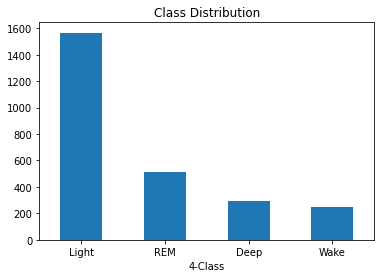

In [29]:
setup_training_data(class_type=Config.class_type, 
                    resampling=Config.resampling.value, 
                    display=True)


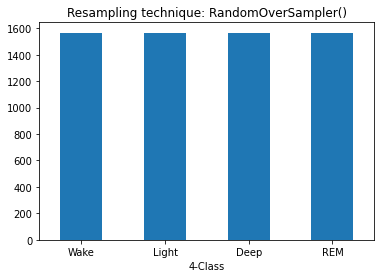

In [30]:
resampling(method=Config.resampling.value,
           class_type=Config.class_type,
           display=True)


In [31]:
Var.X_train

,motion,hr
0,0.788150,0.379543
1,0.150408,0.392662
2,0.020516,0.393423
3,0.001988,0.399344
4,0.000136,0.416846
...,...,...
6259,29.704234,0.411570
6260,0.007392,1.003576
6261,10.298021,1.119601
6262,0.788150,0.379543


In [32]:
Var.y_train.head(100)

0      Wake
1      Wake
2      Wake
3      Wake
4     Light
      ...  
95    Light
96    Light
97    Light
98    Light
99    Light
Name: psg_label, Length: 100, dtype: object

## Parameters Search | Training data

### GridSearch Method

In [33]:
def search_best_params(method=Config.search_method):
    
    print('Parameters-search Method: {} \n'.format(method.value))
    
    # Custom GridSearch 
    if method == SearchParamsMethod.custom:
        grid_best_params, grid_best_model, grid_best_score, cv_report = Tuning.grid_search(data_items=Var.train_set_dict,
                                                                                           clf=Config.classifier,
                                                                                           resampling=Config.resampling.value,
                                                                                           eval_metric=Config.cv_metric,
                                                                                           refit=True)

        print('=========== Custom GridSearchCV Results ===========')
        print('\t Best Params:')
        print(grid_best_params)
        print('\t Best Score:')
        print(grid_best_score)
        
        Var.cv_report = cv_report
        
        Var.final_model = grid_best_model
        
    elif method == SearchParamsMethod.sklearn: # Sklearn lib method
        search_model = LibSearchParams.grid_search(clf=Config.classifier, 
                                               params_grid=ParamsSearch.clf_params_grid,
                                               X_train=Var.X_train,
                                               y_train=Var.y_train)
        
        Var.final_model = search_model.best_estimator_
        
    else: # No need to search parameters
        Var.final_model = ParamsSearch.get_best_classifier(Var.final_model)
        Var.final_model = Classifier.fit(Var.final_model, Var.X_train, Var.y_train)


### Run Parameters Search 

In [34]:
%%time
# Search params or train model if not to search
search_best_params()


Parameters-search Method: Custom-Tuning 


==== Tuning Step #1 ===

++++ Searching Params ++++
---
{'learning_rate': 0.025, 'max_depth': 4, 'objective': 'binary:logistic', 'verbosity': 0}
[9106476] - Score: 0.344 | AUC: 0.616 | k: 0.018 | MCC: 0.019
[9618981] - Score: 0.305 | AUC: 0.673 | k: 0.154 | MCC: 0.196
[9961348] - Score: 0.225 | AUC: 0.597 | k: 0.033 | MCC: 0.043
    Execution time: 0.03 minutes
---
{'learning_rate': 0.025, 'max_depth': 6, 'objective': 'binary:logistic', 'verbosity': 0}
[9106476] - Score: 0.365 | AUC: 0.604 | k: 0.016 | MCC: 0.017
[9618981] - Score: 0.347 | AUC: 0.696 | k: 0.17 | MCC: 0.201
[9961348] - Score: 0.266 | AUC: 0.593 | k: 0.06 | MCC: 0.074
    Execution time: 0.03 minutes
---
{'learning_rate': 0.025, 'max_depth': 8, 'objective': 'binary:logistic', 'verbosity': 0}
[9106476] - Score: 0.378 | AUC: 0.584 | k: 0.006 | MCC: 0.007
[9618981] - Score: 0.365 | AUC: 0.699 | k: 0.172 | MCC: 0.198
[9961348] - Score: 0.263 | AUC: 0.601 | k: 0.04 | MCC: 0.048
    E

# Analysis

## Model Evaluation

In [35]:
Var.final_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.75,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [36]:
check_tester = Var.test_set_dict['1066528']
check_tester

,motion,hr,psg_label
timestamp,,,
1970-01-01 00:00:00,0.000000,0.336561,0.0
1970-01-01 00:00:30,0.000000,0.322855,0.0
1970-01-01 00:01:00,0.002368,0.310544,0.0
1970-01-01 00:01:30,0.017676,0.299575,0.0
1970-01-01 00:02:00,0.050763,0.289984,0.0
...,...,...,...
1970-01-01 07:12:30,7.306551,0.640720,0.0
1970-01-01 07:13:00,6.556466,0.656742,0.0
1970-01-01 07:13:30,7.721542,0.664098,0.0


------ 1066528 -----
{'AUC': 0.702, 'Kappa': 0.219, 'MCC': 0.239, 'Light Acc': 0.146, 'Deep Acc': 0.567, 'REM Acc': 0.689, 'Wake Acc': 0.493}


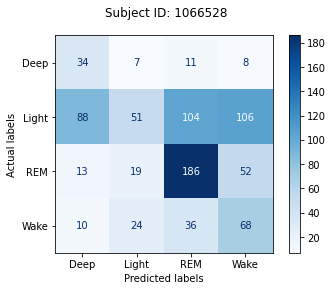

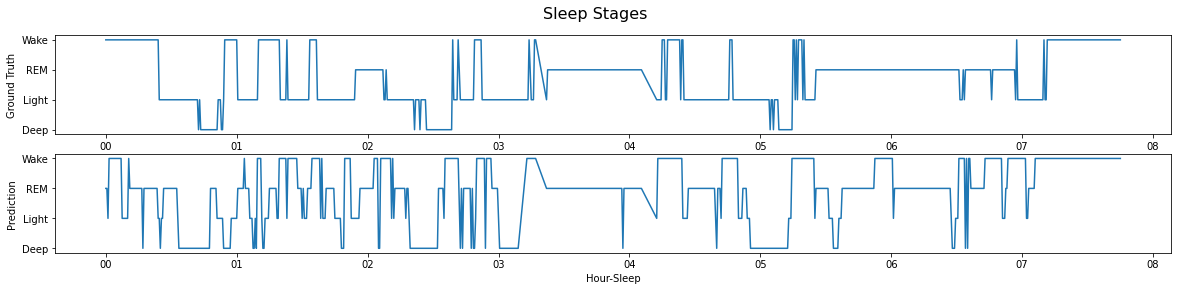

------ 1360686 -----
{'AUC': 0.717, 'Kappa': 0.187, 'MCC': 0.218, 'Light Acc': 0.133, 'Deep Acc': 0.767, 'REM Acc': 0.308, 'Wake Acc': 0.787}


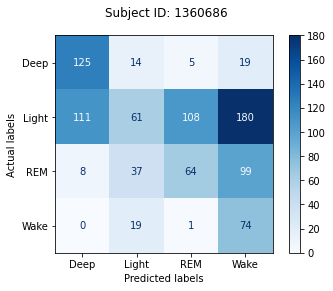

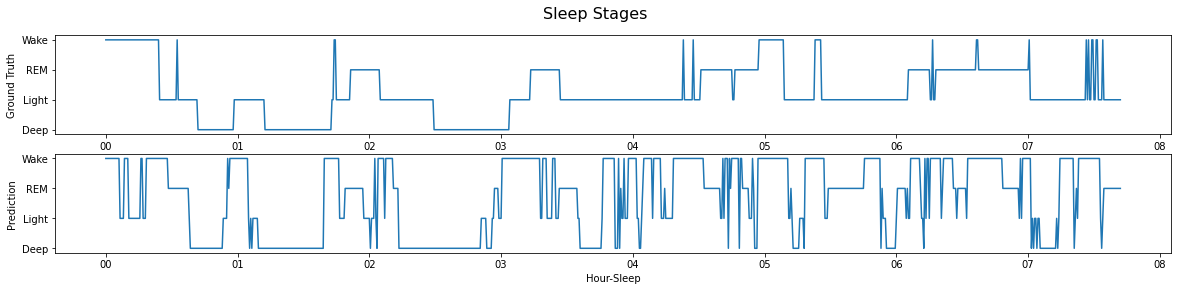

------ 1449548 -----
{'AUC': 0.688, 'Kappa': 0.106, 'MCC': 0.144, 'Light Acc': 0.068, 'Deep Acc': 0.917, 'REM Acc': 0.237, 'Wake Acc': 0.604}


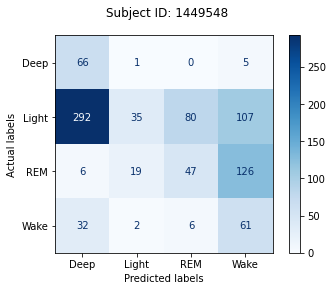

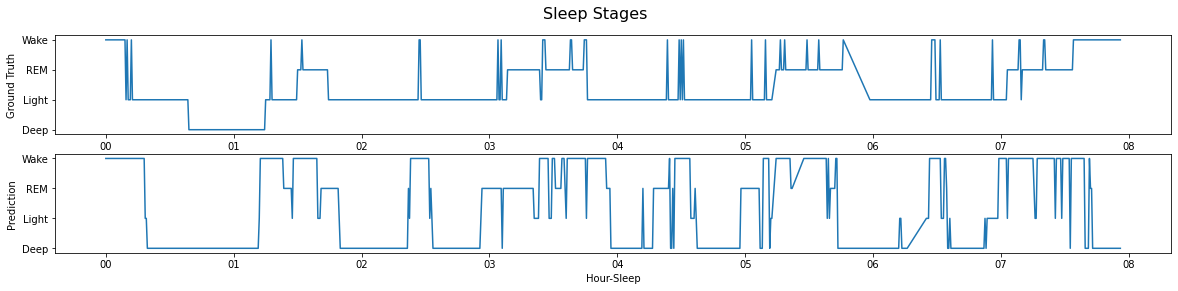

------ 1818471 -----
{'AUC': 0.751, 'Kappa': 0.114, 'MCC': 0.147, 'Light Acc': 0.206, 'Deep Acc': 0.683, 'REM Acc': 0.209, 'Wake Acc': 1.0}


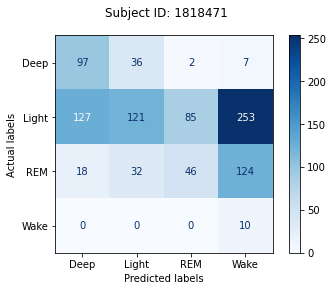

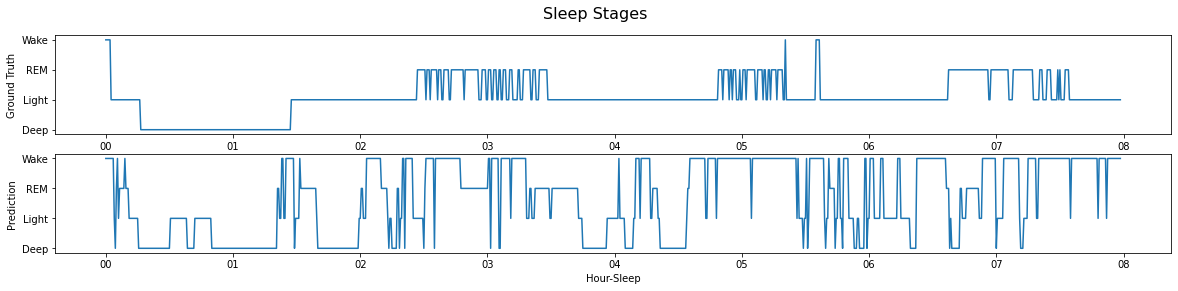

------ 2598705 -----
{'AUC': 0.754, 'Kappa': 0.143, 'MCC': 0.165, 'Light Acc': 0.213, 'Deep Acc': 0.776, 'REM Acc': 0.284, 'Wake Acc': 0.765}


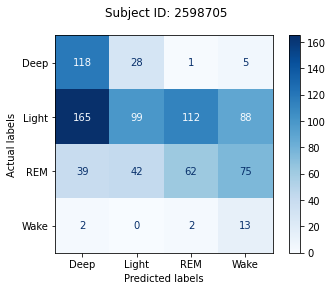

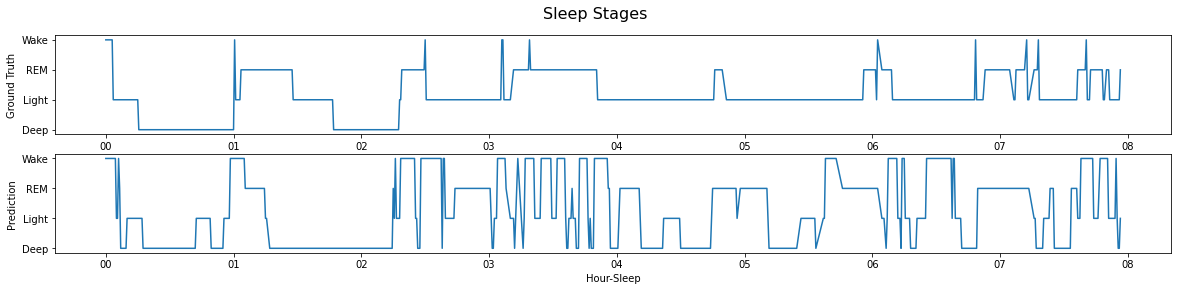

------ 2638030 -----
{'AUC': 0.776, 'Kappa': 0.256, 'MCC': 0.299, 'Light Acc': 0.189, 'Deep Acc': 0.627, 'REM Acc': 0.753, 'Wake Acc': 0.715}


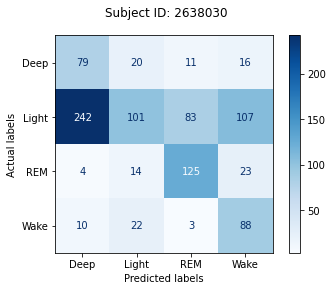

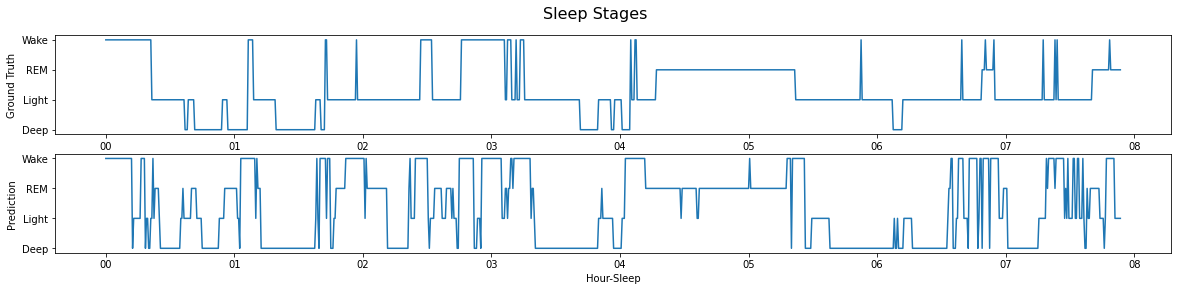

------ 3509524 -----
{'AUC': 0.67, 'Kappa': 0.151, 'MCC': 0.2, 'Light Acc': 0.156, 'Deep Acc': 0.8, 'REM Acc': 0.146, 'Wake Acc': 0.846}


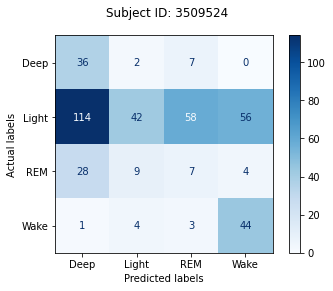

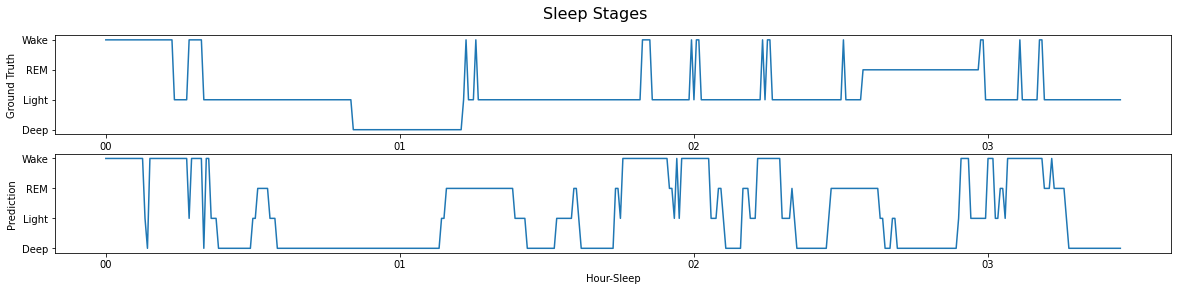

------ 3997827 -----
{'AUC': 0.688, 'Kappa': 0.082, 'MCC': 0.105, 'Light Acc': 0.143, 'Deep Acc': 0.759, 'REM Acc': 0.246, 'Wake Acc': 0.8}


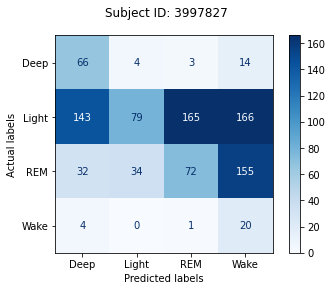

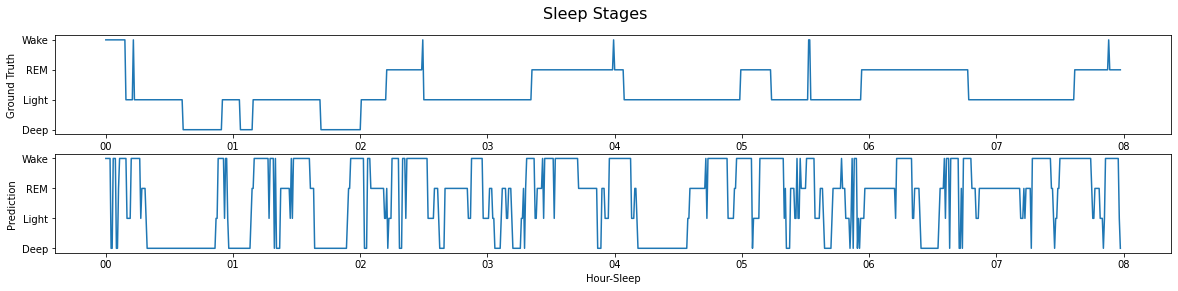

------ 4018081 -----
{'AUC': 0.648, 'Kappa': 0.079, 'MCC': 0.087, 'Light Acc': 0.184, 'Deep Acc': 0.271, 'REM Acc': 0.371, 'Wake Acc': 0.662}


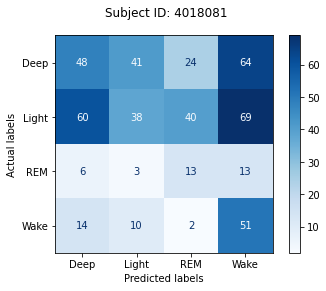

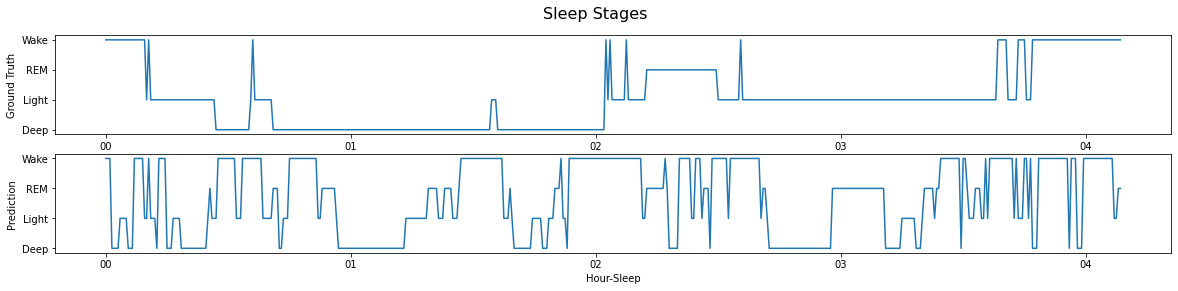

------ 4314139 -----
{'AUC': 0.736, 'Kappa': 0.188, 'MCC': 0.233, 'Light Acc': 0.189, 'Deep Acc': 0.677, 'REM Acc': 0.546, 'Wake Acc': 0.702}


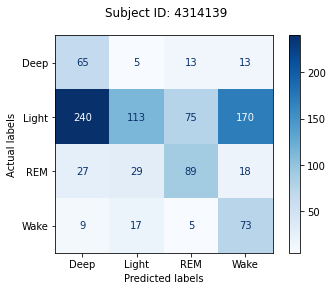

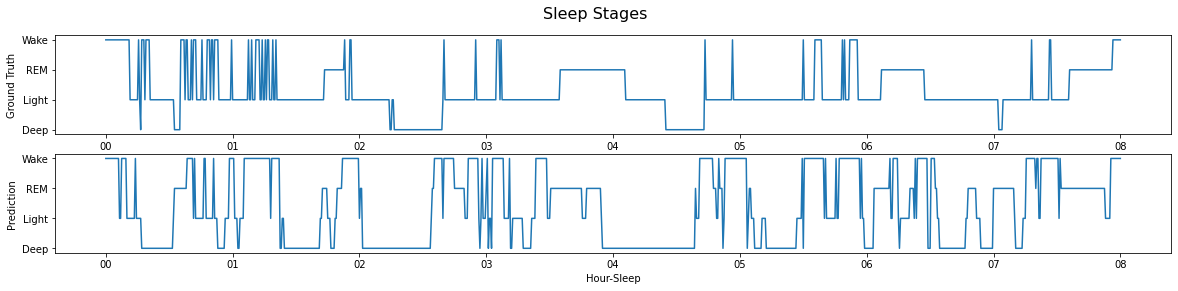

------ 4426783 -----
{'AUC': 0.692, 'Kappa': 0.092, 'MCC': 0.112, 'Light Acc': 0.127, 'Deep Acc': 0.4, 'REM Acc': 0.427, 'Wake Acc': 0.739}


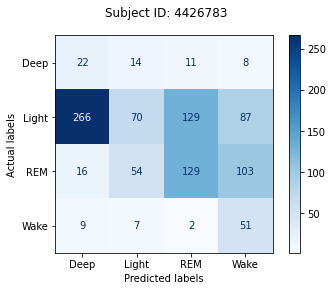

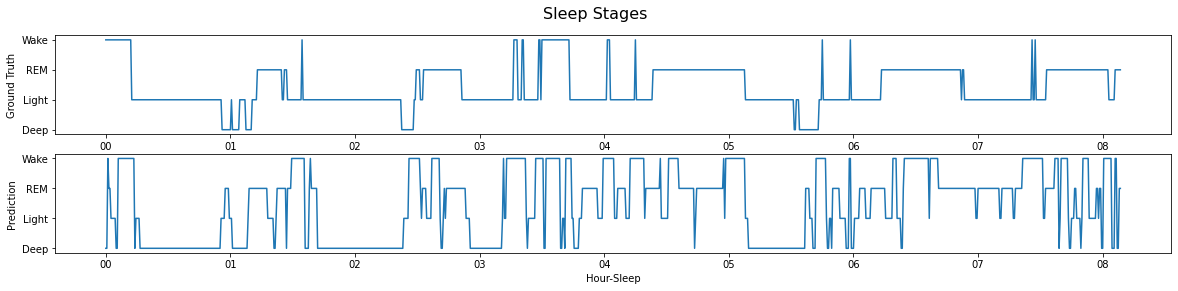

------ 46343 -----
{'AUC': 0.723, 'Kappa': 0.194, 'MCC': 0.211, 'Light Acc': 0.131, 'Deep Acc': 0.712, 'REM Acc': 0.281, 'Wake Acc': 0.583}


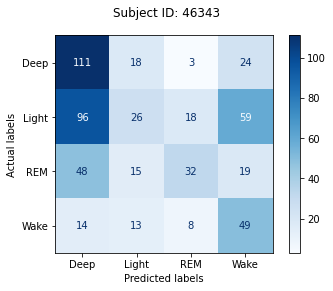

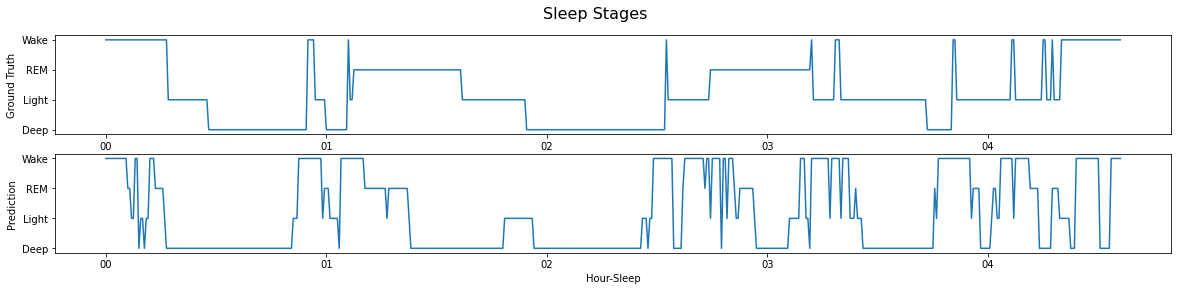

------ 5383425 -----
{'AUC': 0.649, 'Kappa': 0.065, 'MCC': 0.071, 'Light Acc': 0.154, 'Deep Acc': 0.509, 'REM Acc': 0.253, 'Wake Acc': 0.821}


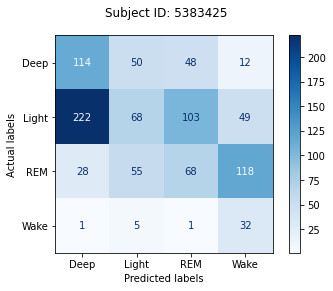

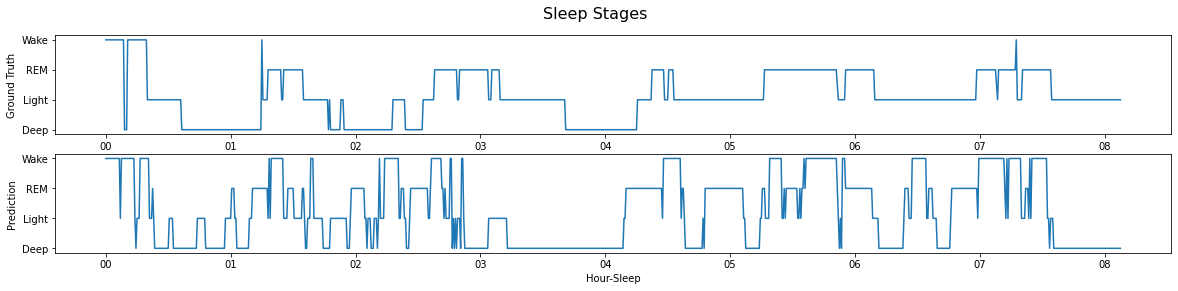

------ 5498603 -----
{'AUC': 0.763, 'Kappa': 0.289, 'MCC': 0.322, 'Light Acc': 0.228, 'Deep Acc': 0.65, 'REM Acc': 0.745, 'Wake Acc': 0.679}


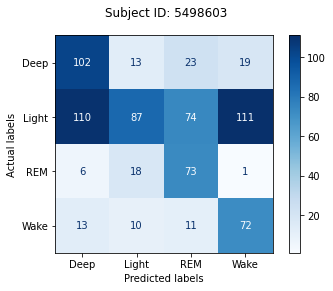

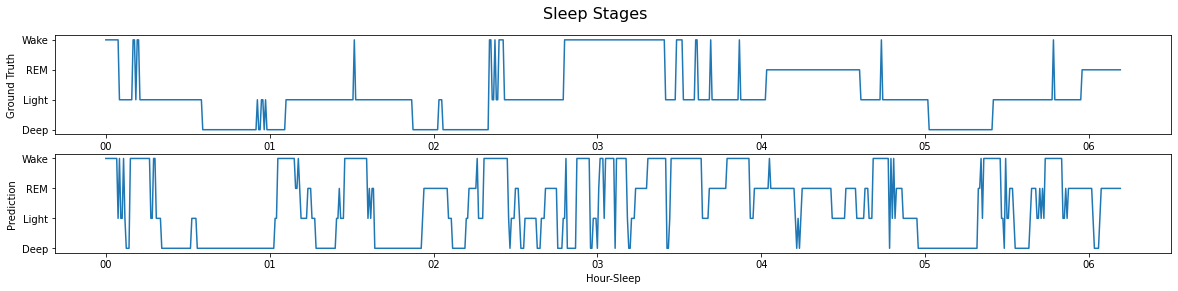

------ 5797046 -----
{'AUC': 0.74, 'Kappa': 0.145, 'MCC': 0.176, 'Light Acc': 0.187, 'Deep Acc': 0.682, 'REM Acc': 0.442, 'Wake Acc': 0.62}


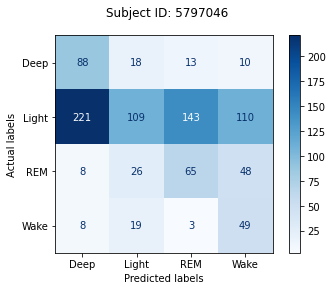

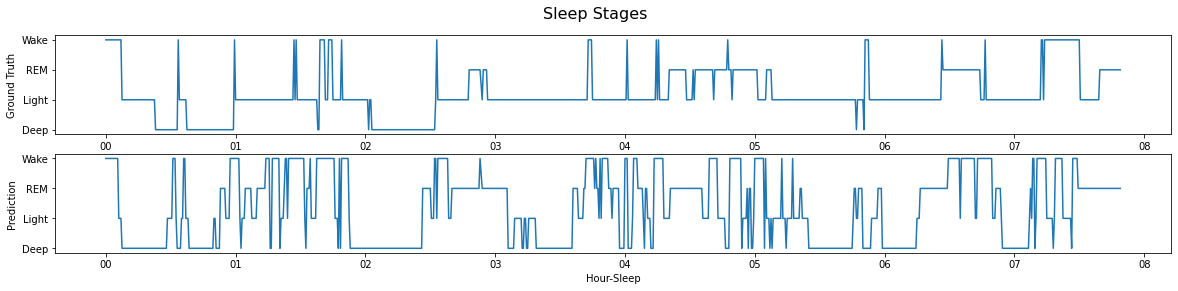

------ 6220552 -----
{'AUC': 0.693, 'Kappa': 0.135, 'MCC': 0.177, 'Light Acc': 0.147, 'Deep Acc': 0.53, 'REM Acc': 0.447, 'Wake Acc': 0.692}


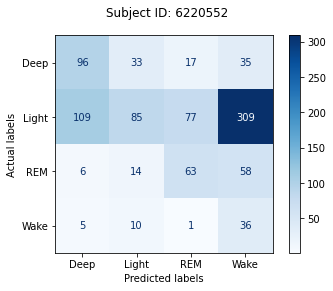

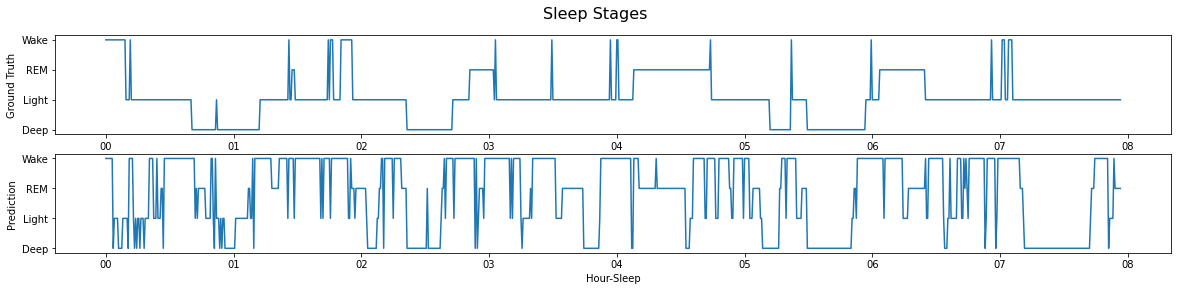

------ 759667 -----
{'AUC': 0.622, 'Kappa': 0.086, 'MCC': 0.097, 'Light Acc': 0.203, 'Deep Acc': 0.518, 'REM Acc': 0.108, 'Wake Acc': 0.529}


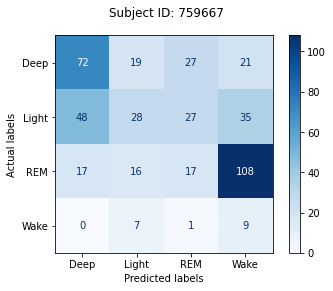

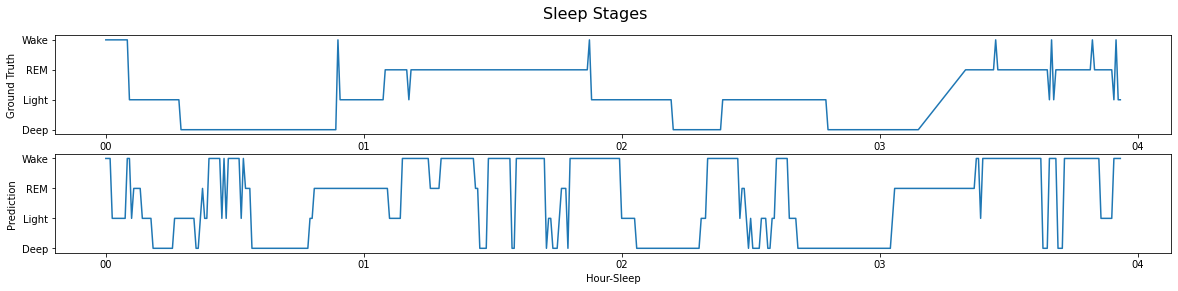

------ 781756 -----
{'AUC': 0.634, 'Kappa': 0.092, 'MCC': 0.114, 'Light Acc': 0.315, 'Deep Acc': 0.174, 'REM Acc': 0.252, 'Wake Acc': 0.695}


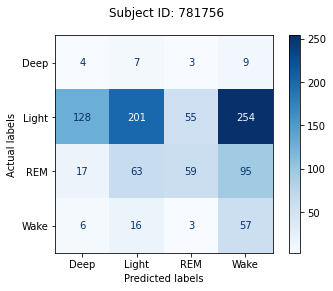

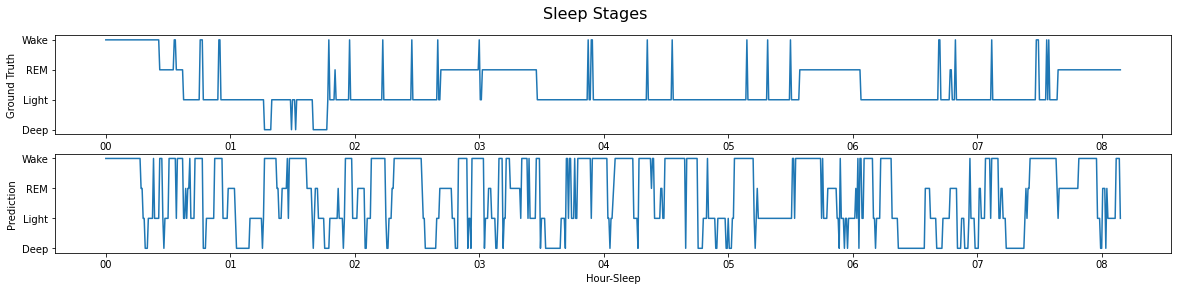

------ 8000685 -----
{'AUC': 0.761, 'Kappa': 0.205, 'MCC': 0.264, 'Light Acc': 0.159, 'Deep Acc': 0.773, 'REM Acc': 0.749, 'Wake Acc': 0.848}


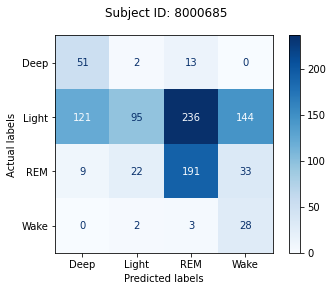

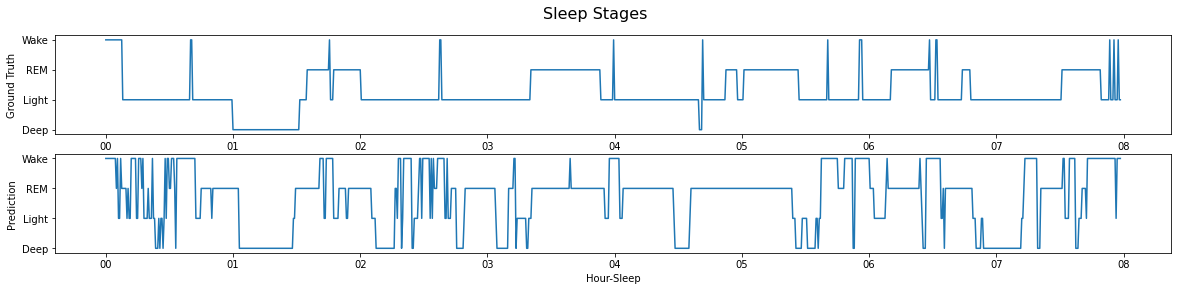

------ 8173033 -----
{'AUC': 0.757, 'Kappa': 0.185, 'MCC': 0.224, 'Light Acc': 0.131, 'Deep Acc': 0.663, 'REM Acc': 0.539, 'Wake Acc': 0.966}


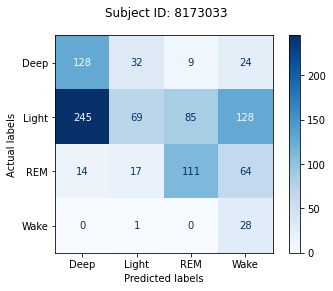

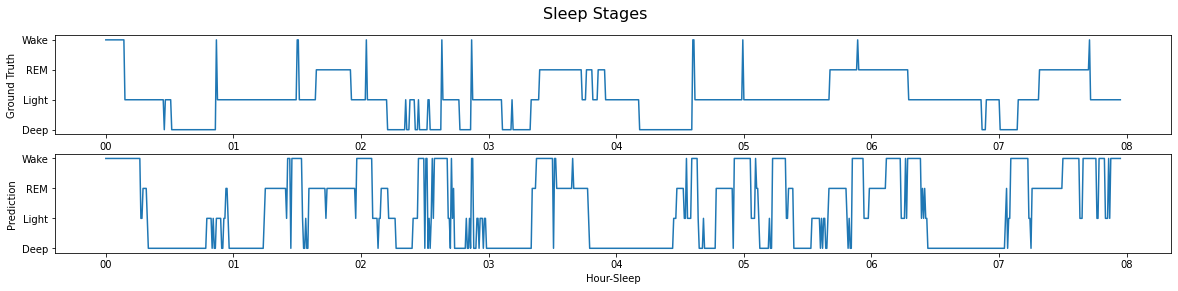

------ 8258170 -----
{'AUC': 0.627, 'Kappa': 0.056, 'MCC': 0.061, 'Light Acc': 0.154, 'Deep Acc': 0.356, 'REM Acc': 0.318, 'Wake Acc': 0.606}


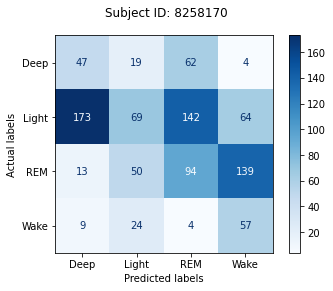

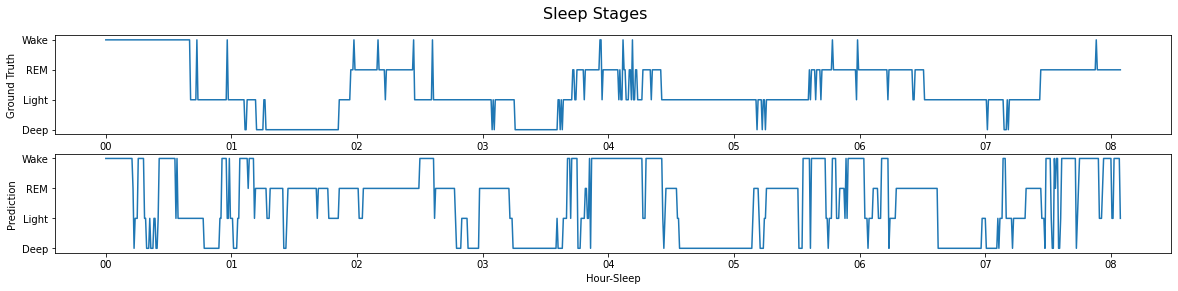

------ 844359 -----
{'AUC': 0.665, 'Kappa': 0.128, 'MCC': 0.149, 'Light Acc': 0.171, 'Deep Acc': 0.184, 'REM Acc': 0.518, 'Wake Acc': 0.848}


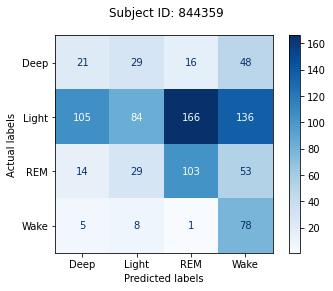

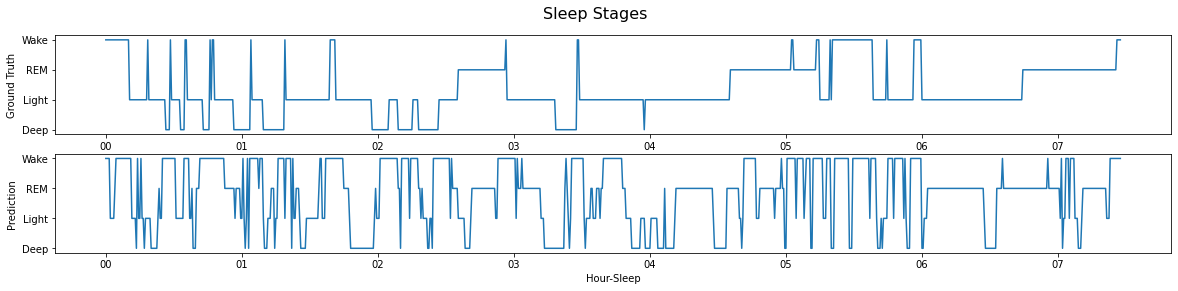

------ 8530312 -----
{'AUC': 0.715, 'Kappa': 0.141, 'MCC': 0.181, 'Light Acc': 0.163, 'Deep Acc': 0.581, 'REM Acc': 0.251, 'Wake Acc': 0.935}


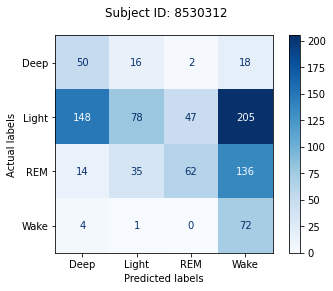

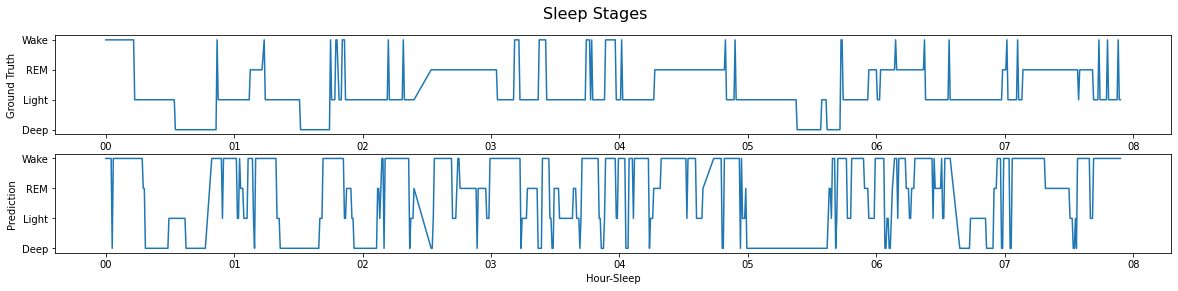

------ 8686948 -----
{'AUC': 0.706, 'Kappa': 0.165, 'MCC': 0.208, 'Light Acc': 0.158, 'Deep Acc': 0.743, 'REM Acc': 0.296, 'Wake Acc': 0.878}


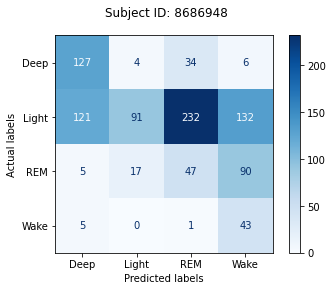

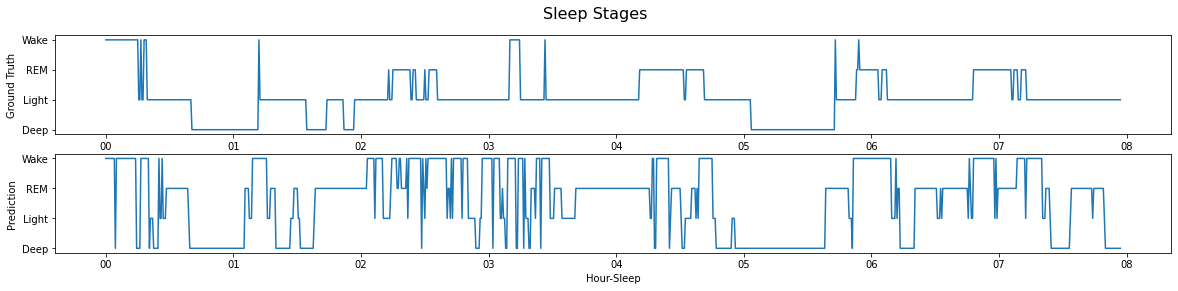

------ 8692923 -----
{'AUC': 0.712, 'Kappa': 0.183, 'MCC': 0.206, 'Light Acc': 0.128, 'Deep Acc': 0.465, 'REM Acc': 0.699, 'Wake Acc': 0.627}


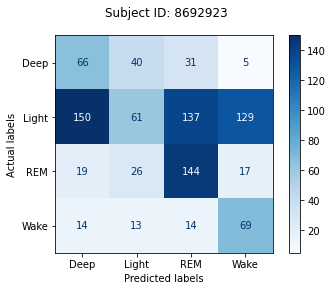

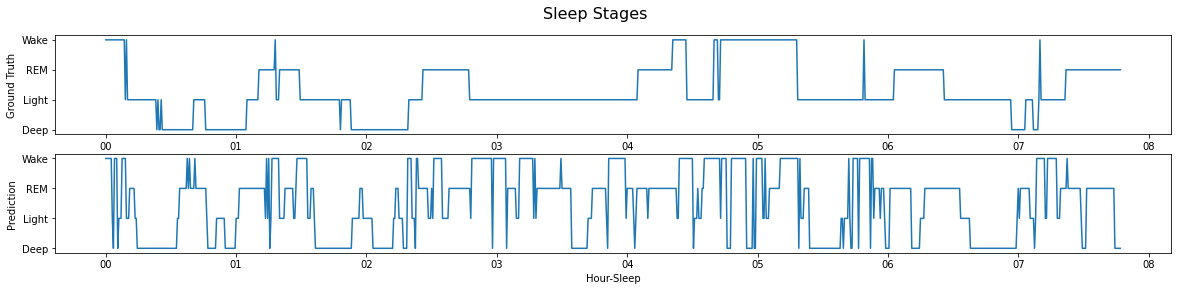

CPU times: user 24.5 s, sys: 7.93 s, total: 32.4 s
Wall time: 8.01 s


In [37]:
%%time

#sleep_wake_score = Performance.score_sleep_wake(Var.final_model)
final_evaluation_score = Performance.score_4class(Var.final_model)


In [38]:
final_evaluation_score


{'AUC': 0.704,
 'Kappa': 0.147,
 'MCC': 0.176,
 'Light Acc': 0.167,
 'Deep Acc': 0.591,
 'REM Acc': 0.405,
 'Wake Acc': 0.738}

In [39]:
#Var.performance_score_dict

In [40]:
# Record performance
record_file_name = '{}_[{}]_{}.csv'.format(
    Config.ml_algorithm.name, Config.class_type.value, Config.resampling.name)
test_performance_path = Constants.EXPORT_PATH + record_file_name
Utils.dict_to_csv(Var.performance_score_dict, test_performance_path)


In [41]:
if Config.search_method is SearchParamsMethod.custom:
    cv_path = Constants.EXPORT_PATH + 'cv_report/'
    Utils.check_path(cv_path)
    cv_file_name = cv_path + '{}_[{}]_{}_(CV-Report).csv'.format(
        Config.ml_algorithm.name, Config.class_type.value, Config.resampling.name)
    Var.cv_report.to_csv(cv_file_name, index=True, header=True)


#### Finish Testing

In [42]:
# Print model parameters
Var.final_model.get_params()


{'objective': 'multi:softprob',
 'use_label_encoder': True,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1.0,
 'gamma': 0.1,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': 8,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': None,
 'subsample': 0.75,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': 0}